Author : **Hajer SOUAIFI-AMARA**

Creation date : 04-MAR-2023

Final date : 17-MAR-2023

Modification date : 17-MAR-2023 - reintroducing ART + IG blood cells from Barcelona dataset and recategorizing images using their labels (IG : IG, MY: MY, MMY and PMY: PMY) and using a single class IG for 'IG', 'MY', 'MMY', 'PMY' 

## Exemples d'images prétraitées et augmentées

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import sys, os
from pathlib import Path
import glob
import time

import PIL
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers

print(tf.__version__)


2.10.0


In [6]:
root_path = 'C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification'
#root_path = '/content/drive/MyDrive/Projet_DS_DataScientest_BCC'
data_path = f'{root_path}/2-Data'

In [7]:
img_df = pd.read_csv(f'{data_path}/BCC_dataset_fin_woOutliers.csv')

C:\Users\amara\AppData\Local\Temp\ipykernel_23620\3660797764.py:1: DtypeWarning: Columns (12,13,14,15,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  img_df = pd.read_csv(f'{data_path}/BCC_dataset_fin_woOutliers.csv')


In [8]:
# Remplacer les valeurs MMC, MYC et PYC par IG dans la colonne "blood_cell"
img_df['blood_cell'] = img_df['blood_cell'].replace(['IG', 'MMC', 'MYC', 'PYC'], 'IG')
img_df.head()

img_id blood_cell_original  \
0  BA_100102            Basophil   
1  BA_101381            Basophil   
2  BA_101611            Basophil   
3  BA_102039            Basophil   
4  BA_102750            Basophil   

                                          image_path     source extension  \
0  C:/Users/amara/Documents/Formation_DS_DataScie...  Barcelona      .jpg   
1  C:/Users/amara/Documents/Formation_DS_DataScie...  Barcelona      .jpg   
2  C:/Users/amara/Documents/Formation_DS_DataScie...  Barcelona      .jpg   
3  C:/Users/amara/Documents/Formation_DS_DataScie...  Barcelona      .jpg   
4  C:/Users/amara/Documents/Formation_DS_DataScie...  Barcelona      .jpg   

   height  width  channels  depth  mean_luminance  ...  Patient_ID  \
0     363    360         3  uint8      201.010843  ...         NaN   
1     363    360         3  uint8      194.197834  ...         NaN   
2     363    360         3  uint8      193.350826  ...         NaN   
3     363    360         3  uint8      188.760063  ...         NaN   
4     363    360         3  uint8      203.143595  ...         NaN   

   slide_type Diagnosis Cohort Age at Diagnosis Gender cell_category  \
0         NaN       NaN    NaN              NaN    NaN      basophil   
1         NaN       NaN    NaN              NaN    NaN      basophil   
2         NaN       NaN    NaN              NaN    NaN      basophil   
3         NaN       NaN    NaN              NaN    NaN      basophil   
4         NaN       NaN    NaN              NaN    NaN      basophil   

   blood_cell  brightness   luminance  
0         BAS  227.090579  201.009514  
1         BAS  221.648225  194.196219  
2         BAS  222.109144  193.343202  
3         BAS  217.042068  188.754761  
4         BAS  229.331057  203.136620  

[5 rows x 23 columns]

In [9]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67616 entries, 0 to 67615
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   img_id               67616 non-null  object 
 1   blood_cell_original  67616 non-null  object 
 2   image_path           67616 non-null  object 
 3   source               67616 non-null  object 
 4   extension            67616 non-null  object 
 5   height               67616 non-null  int64  
 6   width                67616 non-null  int64  
 7   channels             67616 non-null  int64  
 8   depth                67616 non-null  object 
 9   mean_luminance       67616 non-null  float64
 10  std_luminance        67616 non-null  float64
 11  bad_class            32796 non-null  float64
 12  subsource            16480 non-null  object 
 13  Patient_ID           15704 non-null  object 
 14  slide_type           15704 non-null  object 
 15  Diagnosis            15704 non-null 

In [11]:
# Tableau croisé dynamique
crosstabl = pd.crosstab(index=img_df['blood_cell'], columns=img_df['source'])
pourcentages = crosstabl.apply(lambda x: 100 * x / float(x.sum()), axis=1)
crosstabl['Total'] = crosstabl.sum(axis=1)
crosstabl['% Total'] = 100 * crosstabl['Total'] / crosstabl['Total'].sum()
for col in crosstabl.columns[:-2]:
    crosstabl[col + ' %'] = 100 * crosstabl[col] / crosstabl['Total']
print(crosstabl)

source      Barcelona  Kaggle  Munich  Raabin  Total    % Total  Barcelona %  \
blood_cell                                                                     
ART                 0    2992      15       0   3007   4.447172     0.000000   
BAS              1218      53      79     289   1639   2.423982    74.313606   
EOS              3117     108     422    1063   4710   6.965807    66.178344   
ERY              1551     526      78       0   2155   3.187115    71.972158   
IG               2895     922     145       0   3962   5.859560    73.069157   
LYM              1214    3998    3947    3585  12744  18.847610     9.526051   
MON              1420    1385    1814     792   5411   8.002544    26.242839   
MYB                 0    3327    3253       0   6580   9.731425     0.000000   
NEU              3329    2305    8587   10751  24972  36.932087    13.330931   
PLT              2348      88       0       0   2436   3.602698    96.387521   

source       Kaggle %   Munich %   Raab

Test de préprocessing et d'augmentation de données

1. [Prétraitement d'image](https://www.tensorflow.org/guide/keras/preprocessing_layers?hl=fr#image_preprocessing)



In [37]:
# Create a data augmentation stage with rescaling, resizing, horizontal flipping, rotations, zooms, crop
height = 256
width = 256
height_crop = 180
width_crop = 180
data_preprocessing = tf.keras.Sequential(
    [
        layers.Resizing(height=height, width=width, interpolation='nearest',crop_to_aspect_ratio=False), # redimensionne un lot d'images à une taille cible.
        layers.CenterCrop(height=height_crop, width = width_crop), #retourne une culture centrale d'un lot d'images
        layers.Rescaling(scale=1./255), # remet à l' échelle et les décalages des valeurs d'un lot d'images 
    ]
)


2. [Augmentation de données](https://www.tensorflow.org/guide/keras/preprocessing_layers?hl=fr#image_data_augmentation) sur les images préprocessées

In [38]:
# Create a data augmentation stage with rescaling, resizing, horizontal flipping, rotations, zooms, crop
height = 256
width = 256
height_crop = 180
width_crop = 180
data_prep_augmentation = tf.keras.Sequential(
    [
        data_preprocessing,
        layers.RandomFlip("horizontal", seed=42),
        layers.RandomFlip("vertical", seed=42),
        layers.RandomRotation(0.2,interpolation='nearest', seed=42),
        #layers.RandomZoom(0.1, seed=42),
        layers.RandomHeight(0.1, interpolation='nearest', seed=42),
        layers.RandomWidth(0.1, interpolation='nearest', seed=42),
        #layers.RandomContrast(0.1, seed=42)
        #layers.RandomCrop(height=height_crop, width = width_crop, seed=42)
    ]
)

In [65]:
def preprocessing_augmentation_viz(df):
    orig_image_generator = ImageDataGenerator()
    orig_generator = orig_image_generator.flow_from_dataframe(
        dataframe=df_img,
        x_col='image_path',
        y_col='blood_cell',
        target_size=(256, 256),
        batch_size=32,
        subset='training'  # utiliser les données d'entraînement
    )

    # Créer un générateur d'images avec les paramètres de prétraitement définis ci-dessus
    prepro_image_generator = ImageDataGenerator(preprocessing_function=data_preprocessing)
    prepro_generator = prepro_image_generator.flow_from_dataframe(
        dataframe=df_img,
        x_col='image_path',
        y_col='blood_cell',
        target_size=(height_crop, width_crop),
        batch_size=32,
        subset='training'  # utiliser les données d'entraînement
    )

    # Créer un générateur d'images avec les paramètres de prétraitement définis ci-dessus
    prepaug_image_generator = ImageDataGenerator(preprocessing_function=data_prep_augmentation)
    prepaug_generator = prepaug_image_generator.flow_from_dataframe(
        dataframe=df_img,
        x_col='image_path',
        y_col='blood_cell',
        target_size=(height_crop, width_crop),
        batch_size=32,
        subset='training'  # utiliser les données d'entraînement
    )
    # Labels/Index definition :
    label_map = orig_generator.class_indices

    # Obtenir les noms de toutes les catégories d'images
    categories = list(label_map.keys())
    print(categories)
    
    # obtenir les chemins des images à partir des générateurs d'images
    prepro_image_paths = prepro_generator.filepaths
    orig_image_paths = prepro_image_paths
    prepaug_image_paths = prepro_image_paths

    # obtenir les étiquettes d'image à partir des générateurs d'images
    prepro_image_labels = prepro_generator.labels
    orig_image_labels = prepro_image_labels
    prepaug_image_labels = prepro_image_labels

    # créer un dictionnaire pour stocker une image par catégorie pour chaque générateur d'images
    orig_images_dict = {}
    prepro_images_dict = {}
    prepaug_images_dict = {}
    paths =[]
    # parcourir toutes les catégories
    for cat in categories:
        # trouver l'indice de la première image de la catégorie dans le générateur d'images original
        cat_labels = np.array(label_map[cat])
        orig_cat_idx = np.where(prepro_image_labels == cat_labels)[0][0]
        # trouver le chemin d'image correspondant
        orig_image_path = orig_image_paths[orig_cat_idx]
        # charger l'image
        orig_image = load_img(orig_image_path, target_size=(256, 256))
        # ajouter l'image au dictionnaire
        orig_images_dict[cat] = orig_image

        # trouver l'indice de la première image de la catégorie dans le générateur d'images préprocessé
        prepro_cat_idx = np.where(prepro_image_labels == cat_labels)[0][0]
        # trouver le chemin d'image correspondant
        prepro_image_path = prepro_image_paths[prepro_cat_idx]
        print(prepro_image_path)
        # charger l'image
        prepro_image = load_img(prepro_image_path, target_size=(256, 256))
        prepro_image = tf.keras.preprocessing.image.img_to_array(prepro_image)
        prepro_image = data_preprocessing(prepro_image)
        # ajouter l'image au dictionnaire
        prepro_images_dict[cat] = prepro_image

        # trouver l'indice de la première image de la catégorie dans le générateur d'images préprocessé 
        # et augmenté
        prepaug_cat_idx = np.where(prepaug_image_labels == cat_labels)[0][0]
        # trouver le chemin d'image correspondant
        prepaug_image_path = prepaug_image_paths[prepaug_cat_idx]
        print(prepaug_image_path)
        # charger l'image
        prepaug_image = load_img(prepaug_image_path) #, target_size=(256, 256)
        prepaug_image = tf.keras.preprocessing.image.img_to_array(prepaug_image)
        prepaug_image = data_prep_augmentation(prepaug_image)
        # ajouter l'image au dictionnaire
        prepaug_images_dict[cat] = prepaug_image

    # afficher les images de chaque catégorie pour chaque générateur d'images
    fig, axes = plt.subplots(len(categories), 3, figsize=(8, 16))
    for i, cat in enumerate(categories):
        # afficher l'image originale
        axes[i][0].imshow(orig_images_dict[cat])
        axes[i][0].set_title(cat +"\n Original Image")
        axes[i][0].axis('off')

        # afficher l'image préprocessée
        axes[i][1].imshow(prepro_images_dict[cat])
        axes[i][1].set_title(cat +"\n Preprocessed Image")
        axes[i][1].axis('off')

        # afficher l'image préprocessée et augmentée
        axes[i][2].imshow(prepaug_images_dict[cat])
        axes[i][2].set_title(cat +"\n Preprocessed &" +"\n Augmented Image")
        axes[i][2].axis('off')

    plt.tight_layout()
    plt.show()
    return

Found 17092 validated image filenames belonging to 8 classes.
Found 17092 validated image filenames belonging to 8 classes.
Found 17092 validated image filenames belonging to 8 classes.
['BAS', 'EOS', 'ERY', 'IG', 'LYM', 'MON', 'NEU', 'PLT']
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/PBC_dataset_normal_DIB/basophil\BA_100102.jpg
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/PBC_dataset_normal_DIB/basophil\BA_100102.jpg
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/PBC_dataset_normal_DIB/eosinophil\EO_100213.jpg
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/PBC_dataset_normal_DIB/eosinophil\EO_100213.jpg
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classifica

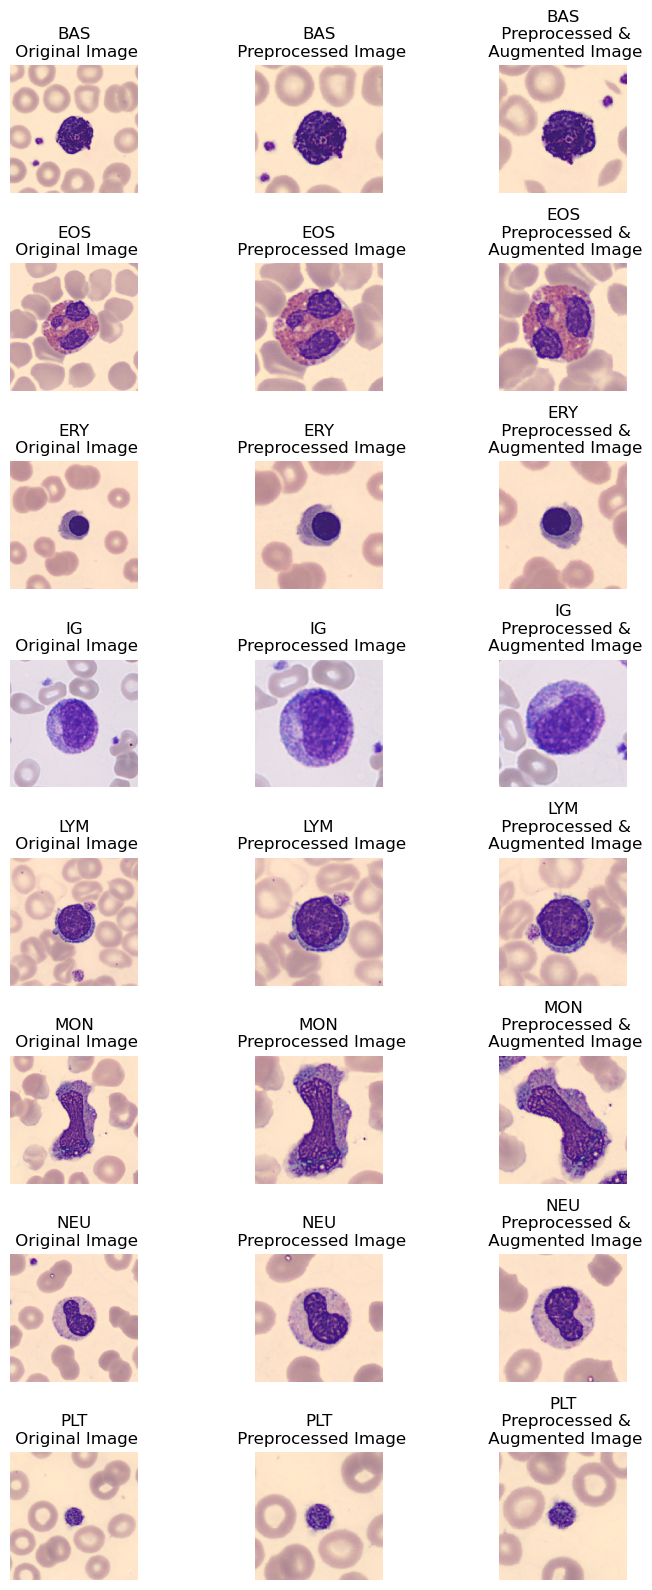

In [66]:
df_img= img_df[img_df['source']=='Barcelona']
preprocessing_augmentation_viz(df_img)

Found 15704 validated image filenames belonging to 10 classes.
Found 15704 validated image filenames belonging to 10 classes.
Found 15704 validated image filenames belonging to 10 classes.
['ART', 'BAS', 'EOS', 'ERY', 'IG', 'LYM', 'MON', 'MYB', 'NEU', 'PLT']
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/All/Patient_00\Signed slides\Smudge cells\SMU_15336337.jpg
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/All/Patient_00\Signed slides\Smudge cells\SMU_15336337.jpg
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/All/Patient_02\Signed slides\Basophil\BA_5899689.jpg
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/All/Patient_02\Signed slides\Basophil\BA_5899689.jpg
C:/Users/amara/Documents/Formation_DS_DataSciente

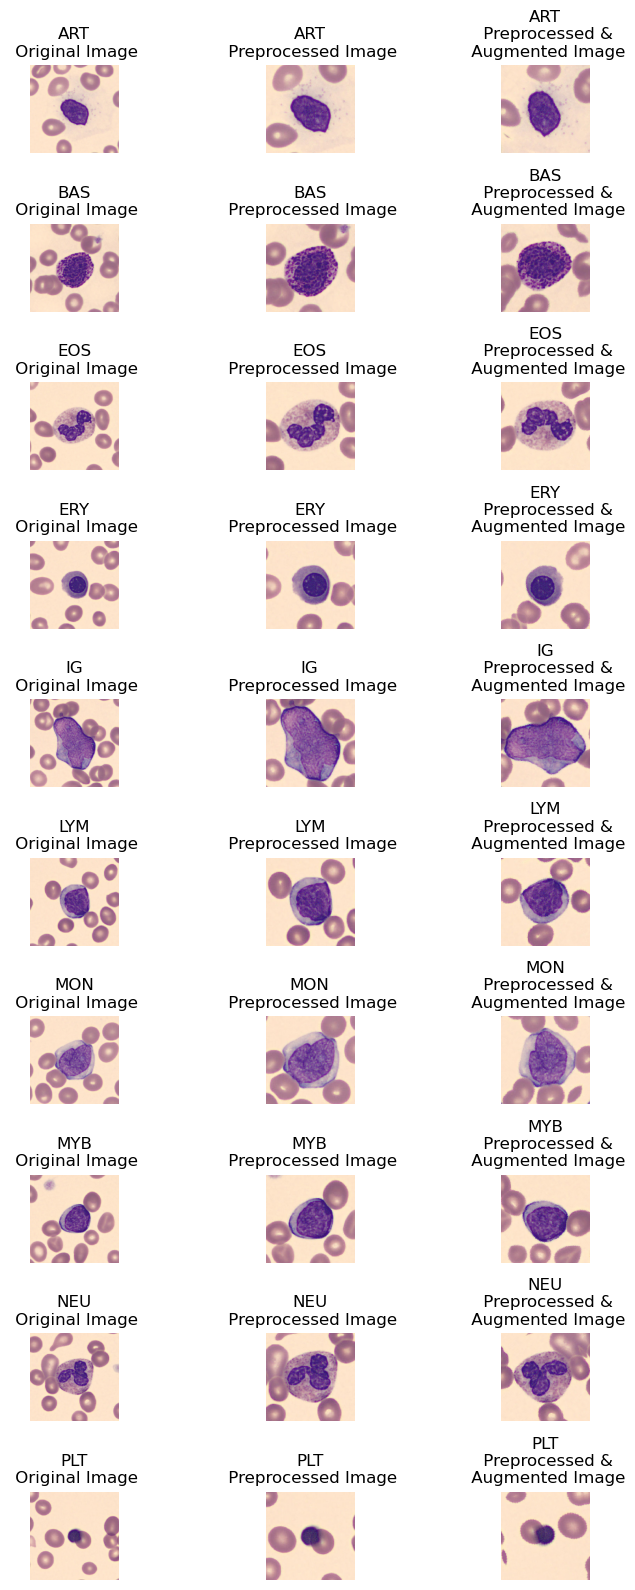

In [67]:
df_img= img_df[img_df['source']=='Kaggle']
preprocessing_augmentation_viz(df_img)

Found 16480 validated image filenames belonging to 5 classes.
Found 16480 validated image filenames belonging to 5 classes.
Found 16480 validated image filenames belonging to 5 classes.
['BAS', 'EOS', 'LYM', 'MON', 'NEU']
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/Raabin/Train\Basophil\20190526_162951_0.jpg
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/Raabin/Train\Basophil\20190526_162951_0.jpg
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/Raabin/Train\Eosinophil\95-5-10-1_1057_1.jpg
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/Raabin/Train\Eosinophil\95-5-10-1_1057_1.jpg
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/Raabin/Train\Ly

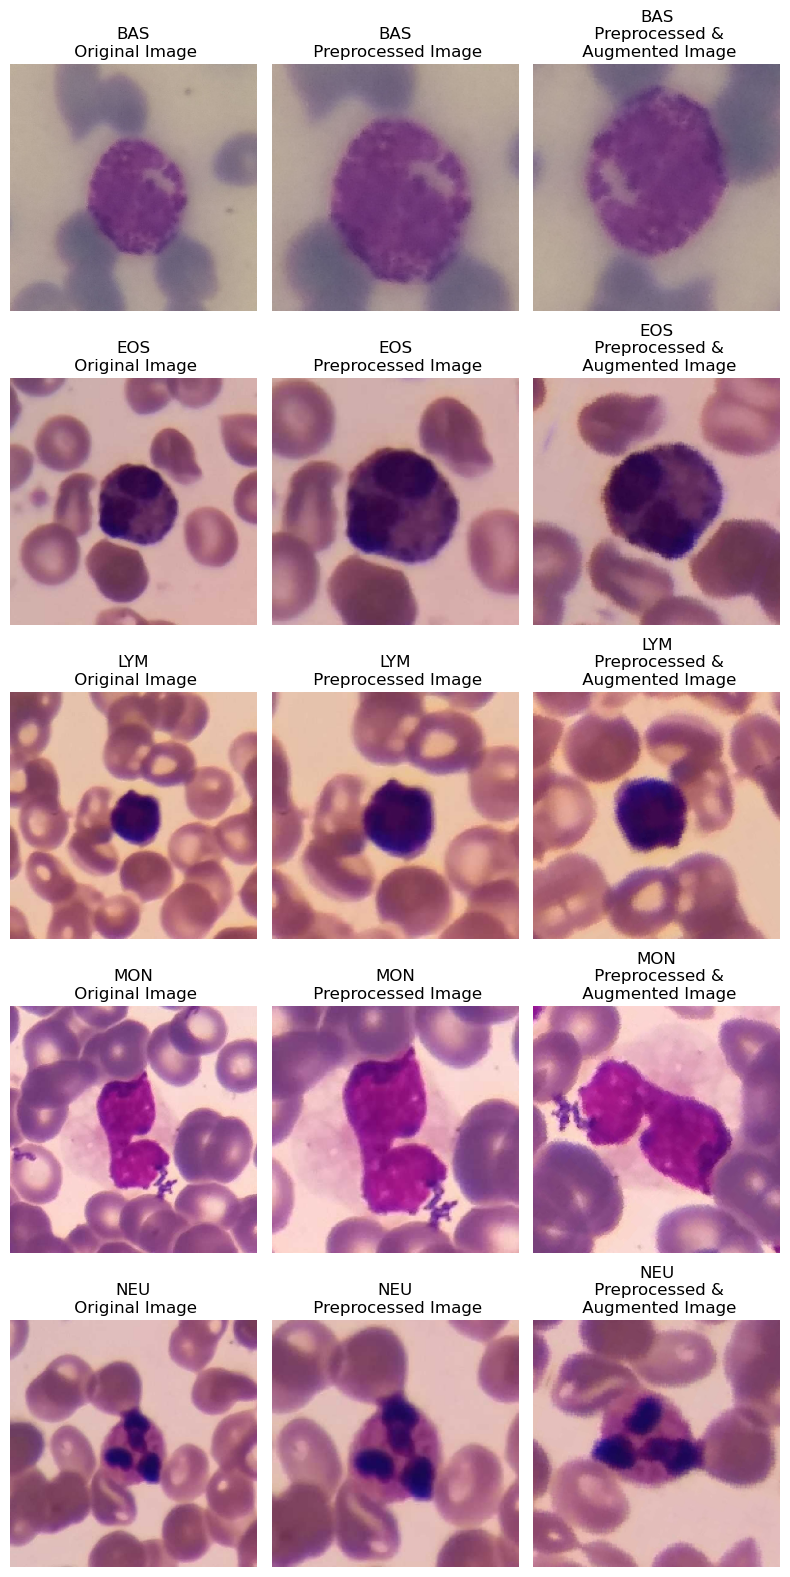

In [68]:
df_img= img_df[img_df['source']=='Raabin']
preprocessing_augmentation_viz(df_img)

Found 18340 validated image filenames belonging to 9 classes.
Found 18340 validated image filenames belonging to 9 classes.
Found 18340 validated image filenames belonging to 9 classes.
['ART', 'BAS', 'EOS', 'ERY', 'IG', 'LYM', 'MON', 'MYB', 'NEU']
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/Munich/PKG - AML-Cytomorphology/AML-Cytomorphology\KSC\KSC_0001.tiff
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/Munich/PKG - AML-Cytomorphology/AML-Cytomorphology\KSC\KSC_0001.tiff
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/Munich/PKG - AML-Cytomorphology/AML-Cytomorphology\BAS\BAS_0001.tiff
C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification/2-RawData/Munich/PKG - AML-Cytomorphology/AML-Cytomorphology\BAS\BAS_0001.tiff
C:/User

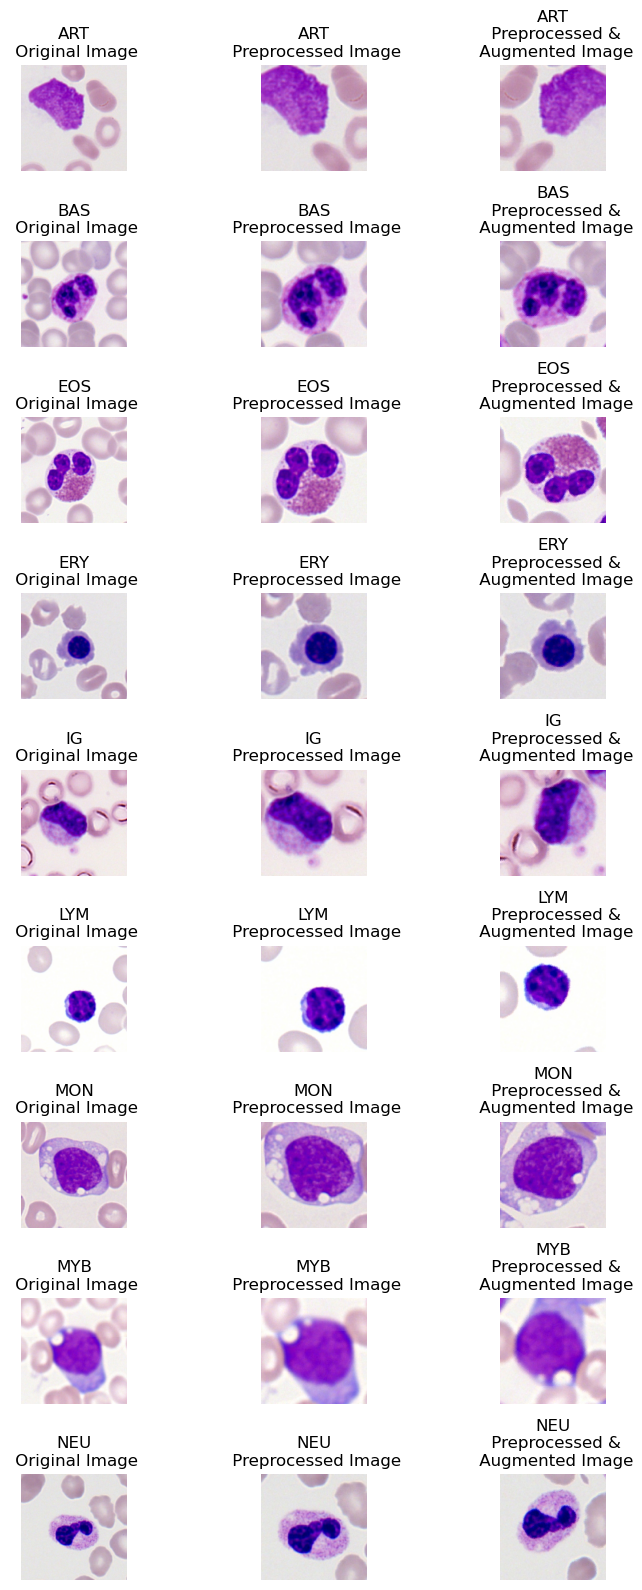

In [69]:
df_img= img_df[img_df['source']=='Munich']
preprocessing_augmentation_viz(df_img)